In [122]:
from fastai.vision.all import *
from pathlib import Path

In [2]:
root = ROOT_PATH = Path(r"C:\Users\xx\Desktop\Workspace\selfcurenetwork-own\RAF-DB")

df = pd.read_csv(root/"EmoLabel/combined_Tqinghua.txt", sep=' ', header=0, names=["filename", "label"])

df.iloc[:, 0] = df.iloc[:, 0].str[:-4] + "_aligned" + ".jpg"

In [3]:
# Convert number to emotion
# 0:Surprise, 1:Fear, 2:Disgust, 3:Happiness, 4:Sadness, 5:Anger, 6:Neutral
conversion = {
    1: "surprise",
    2: "fear",
    3: "disgust",
    4: "happy",
    5: "sad",
    6: "angry",
    7: "neutral"
}

df.iloc[:, 1].replace(conversion, inplace=True)

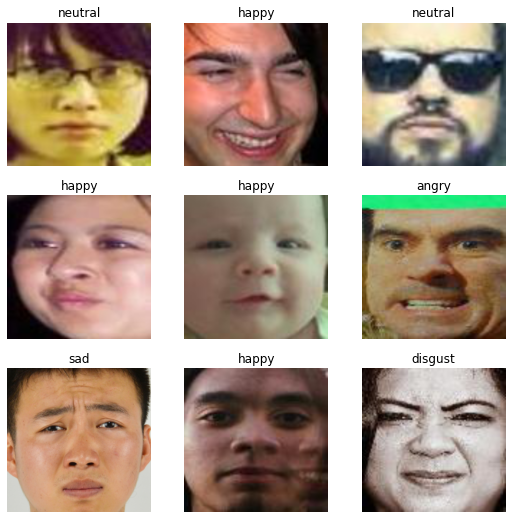

In [4]:
dls = ImageDataLoaders.from_df(df, root, folder="Image/combined_Tsinghua", num_workers=0, item_tfms=Resize(460))
dls.show_batch()

In [5]:
# Create new column in df to prepare for oversampling
train_df = dls.train.items.copy(deep=True).reset_index(drop=True)
train_df["is_valid"] = False

valid_df = dls.valid.items.copy(deep=True).reset_index(drop=True)
valid_df["is_valid"] = True

In [6]:
# Oversample only the training
# train_df["label"].value_counts()

def oversample(frame: pd.DataFrame):
    max_size = frame['label'].value_counts().max()
    lst = [frame]
    for class_index, group in frame.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(lst)

oversampled_train_df = oversample(train_df) # <------- TRAINING DATAFRAME ONLY
# oversampled_train_df['label'].value_counts()

In [7]:
# Create new dataloader
oversampled_df = pd.concat((oversampled_train_df, valid_df)).reset_index(drop=True)
oversampled_dls = ImageDataLoaders.from_df(oversampled_df, root, valid_col="is_valid", folder="Image/combined_Tsinghua", item_tfms=Resize(460), batch_tfms=aug_transforms(size=224), num_workers=0)
# oversampled_df.head()

In [8]:
# oversampled_df

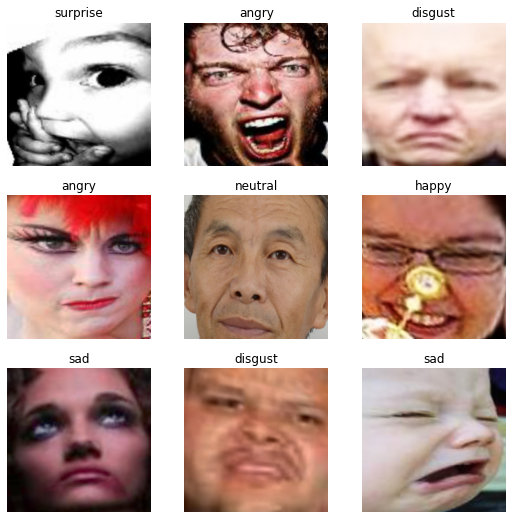

In [9]:
oversampled_dls.show_batch()

In [15]:
'''
# Add in test set
# Test on NTU data
test_path = Path(r"C:\Users\xx\Desktop\Workspace\selfcurenetwork-own\NTU-Data\manual-relabel")
# test_path.ls()

test_files = get_image_files(test_path)
test_dl = oversampled_dls.test_dl(test_files)
oversampled_dls.loaders.append(test_dl)
'''

In [10]:
cbs = [EarlyStoppingCallback(monitor='valid_loss', min_delta=0.005, patience=5), SaveModelCallback(monitor="valid_loss"), MixUp()]


In [11]:
learn = cnn_learner(oversampled_dls, resnet18, metrics=[accuracy], loss_func=LabelSmoothingCrossEntropy())


### Training Model ###

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=1.9054607491852948e-06)

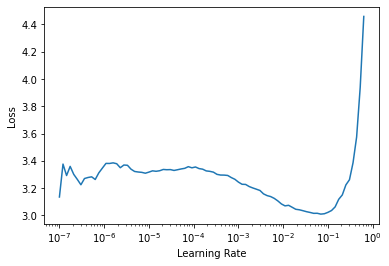

In [17]:
learn.lr_find()

In [15]:
10e-

1.0

In [37]:
learn.fine_tune(40, base_lr=3e-3 , freeze_epochs=5, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,2.099320,1.674415,0.424261,20:11
1,1.642183,1.473153,0.499552,17:47
2,1.508429,1.379114,0.548850,10:41
3,1.451828,1.299469,0.598148,10:43
4,1.339735,1.197926,0.649537,10:43


Better model found at epoch 0 with valid_loss value: 1.6744154691696167.
Better model found at epoch 1 with valid_loss value: 1.4731528759002686.
Better model found at epoch 2 with valid_loss value: 1.379113793373108.
Better model found at epoch 3 with valid_loss value: 1.299468994140625.
Better model found at epoch 4 with valid_loss value: 1.1979255676269531.


epoch,train_loss,valid_loss,accuracy,time
0,1.125535,1.010906,0.752316,08:48
1,1.000180,0.937344,0.788766,08:06
2,0.944906,0.897713,0.806693,07:55
3,0.895352,0.899048,0.800418,08:00
4,0.841262,0.906512,0.802808,08:03
5,0.814974,0.889730,0.811174,07:57
6,0.803010,0.873572,0.820436,07:55
7,0.794202,0.858717,0.822826,07:57
8,0.771771,0.850859,0.827009,08:08
9,0.743252,0.839417,0.832387,08:08


Better model found at epoch 0 with valid_loss value: 1.0109063386917114.
Better model found at epoch 1 with valid_loss value: 0.937343955039978.
Better model found at epoch 2 with valid_loss value: 0.8977130055427551.
Better model found at epoch 5 with valid_loss value: 0.8897300362586975.
Better model found at epoch 6 with valid_loss value: 0.8735722899436951.
Better model found at epoch 7 with valid_loss value: 0.8587167859077454.
Better model found at epoch 8 with valid_loss value: 0.8508594632148743.
Better model found at epoch 9 with valid_loss value: 0.8394170999526978.
Better model found at epoch 10 with valid_loss value: 0.8284541964530945.
No improvement since epoch 10: early stopping


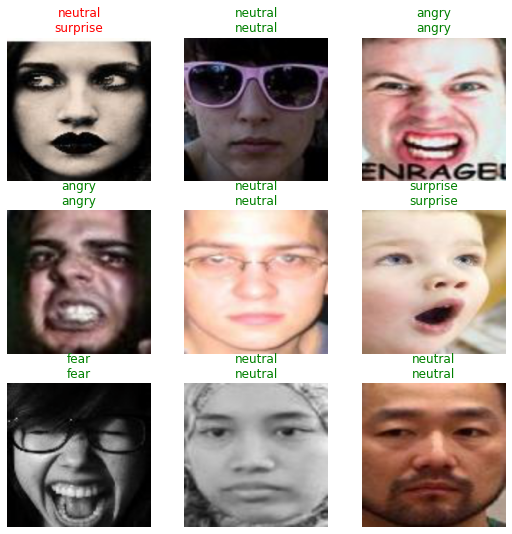

In [25]:
# learn.show_results()

In [26]:
# interp = ClassificationInterpretation.from_learner(learn)

In [26]:
# interp.plot_confusion_matrix(figsize=(3,3))

In [28]:
# interp.plot_top_losses(9, figsize=(15,10))

In [38]:
# learn.save("model-7jan")

Path('C:/Users/xx/Desktop/Workspace/selfcurenetwork-own/RAF-DB/models/model-7jan.pth')

In [123]:
learn.load("model7janpart2")

In [124]:
interp = ClassificationInterpretation.from_learner(learn)

In [125]:
# interp.decoded

In [126]:
interp.print_classification_report()

              precision    recall  f1-score   support

       angry       0.96      0.96      0.96       228
     disgust       0.97      0.91      0.94       234
        fear       0.97      0.95      0.96       103
       happy       0.98      0.98      0.98      1243
     neutral       0.93      0.97      0.95       641
         sad       0.98      0.96      0.97       544
    surprise       0.96      0.96      0.96       354

    accuracy                           0.97      3347
   macro avg       0.97      0.96      0.96      3347
weighted avg       0.97      0.97      0.97      3347



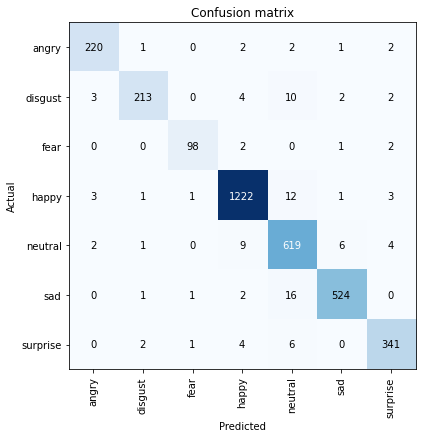

In [127]:
interp.plot_confusion_matrix(figsize=(6,6))

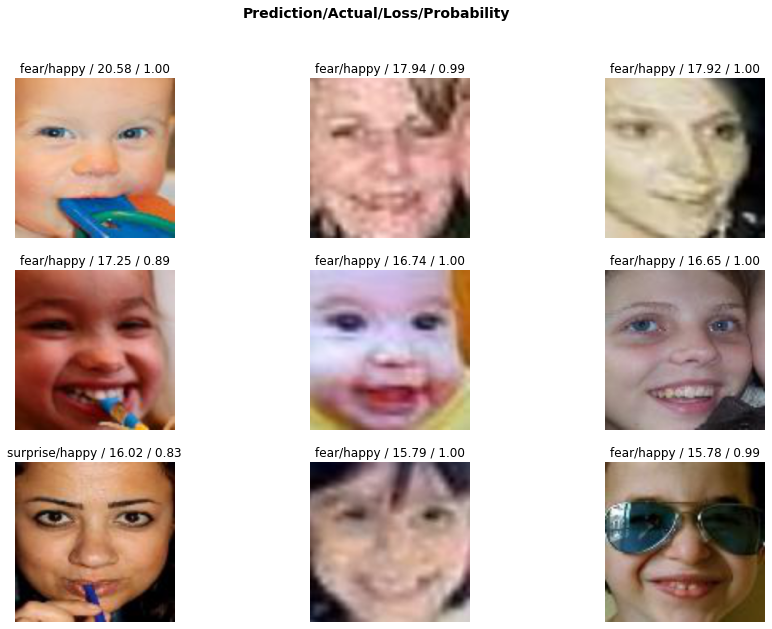

In [33]:
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
# oversampled_dls.vocab

Confusion matrix, without normalization
[[ 76   0   2   3   0   3  14]
 [  9   2  17  17   9  38   5]
 [  0  10  51  11  28  17  11]
 [  1   0   2 335   0   0  20]
 [  0   1   4   4  54   0  47]
 [  2   0  41  11   2  58  12]
 [  0   0   0  10  17   0 130]]


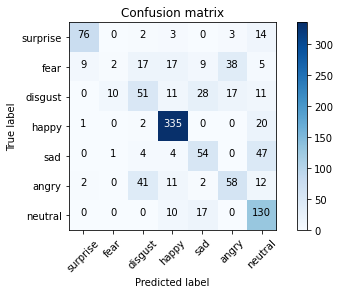

              precision    recall  f1-score   support

    surprise       0.86      0.78      0.82        98
        fear       0.15      0.02      0.04        97
     disgust       0.44      0.40      0.42       128
       happy       0.86      0.94      0.89       358
         sad       0.49      0.49      0.49       110
       angry       0.50      0.46      0.48       126
     neutral       0.54      0.83      0.66       157

    accuracy                           0.66      1074
   macro avg       0.55      0.56      0.54      1074
weighted avg       0.62      0.66      0.63      1074



In [129]:
root_path = Path(r"C:\Users\xx\Desktop\Workspace\selfcurenetwork-own\NTU-Data\manual-relabel")
emotion7_list = ["surprise","fear","disgust","happy","sad","angry","neutral"]
filenames = get_image_files(root_path)
preds = []
targs = []


for filename in filenames:
    pred = learn.predict(filename)[0]
    pred = emotion7_list.index(pred)
    target = emotion7_list.index(filename.parent.name)
    preds.append(pred)
    targs.append(target)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools


cm = confusion_matrix(targs, preds)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(cm, emotion7_list)

from sklearn.metrics import classification_report

print(classification_report(targs, preds, target_names=emotion7_list))